In this notebook, we will build a movie recommender system

   ### import dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [4]:
# Get the dataset
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2023-07-23 19:29:10--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv’

tmdb_5000_movies.cs 100%[===================>]   5.43M   487KB/s    in 12s     

2023-07-23 19:29:32 (475 KB/s) - ‘tmdb_5000_movies.csv’ saved [5698602/5698602]



In [5]:
# load dataset
df = pd.read_csv("tmdb_5000_movies.csv")

In [6]:
#preview 
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [9]:
#we will use the genre and keywords column for our recommender system
# Experiment with 1 row
x = df.iloc[0]

In [11]:
x

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [13]:
x['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [18]:
j = json.loads(x['genres'])
j

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [16]:
x['keywords']

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [19]:
k = json.loads(x['keywords'])
k

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [20]:
# join all the names
' '.join(''.join(jj['name'].split()) for jj in j)

'Action Adventure Fantasy ScienceFiction'

In [24]:
# Define function to convert each row to single strings

def convert_to_strings(row):
    genres = json.loads(row['genres'])
    genres =  ' '.join(''.join(j['name'].split()) for j in genres)
    keywords = json.loads(row['keywords'])
    keywords =  ' '.join(''.join(j['name'].split()) for j in keywords)
    return "{:s} {:s}".format(genres, keywords)

In [25]:
#Get a new column strings 
df['strings'] = df.apply(convert_to_strings, axis = 1)

In [26]:
df.strings

0       Action Adventure Fantasy ScienceFiction cultur...
1       Adventure Fantasy Action ocean drugabuse exoti...
2       Action Adventure Crime spy basedonnovel secret...
3       Action Crime Drama Thriller dccomics crimefigh...
4       Action Adventure ScienceFiction basedonnovel m...
                              ...                        
4798    Action Crime Thriller unitedstates–mexicobarri...
4799                                      Comedy Romance 
4800    Comedy Drama Romance TVMovie date loveatfirsts...
4801                                                     
4802      Documentary obsession camcorder crush dreamgirl
Name: strings, Length: 4803, dtype: object

In [27]:
# create a tf-idf vectorizer object
tfidf = TfidfVectorizer(max_features=2000)

In [31]:
x = tfidf.fit_transform(df['strings'])

In [32]:
x

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

In [35]:
# generate a mapping from movie title -> index (in df)
movie2idx = pd.Series(df.index, index = df.title)

In [41]:
idx = movie2idx['Scream 3']
idx

1164

In [44]:
query = x[idx]

In [45]:
# check similarity ofa movies with others
scores = cosine_similarity(query,x)


In [48]:
scores = scores.flatten()

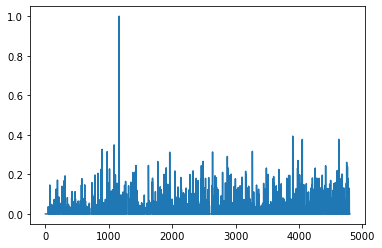

In [50]:
#plot scores
plt.plot(scores)

In [52]:
(-scores).argsort()

array([1164, 3902, 4628, ..., 1714, 1720, 4802])

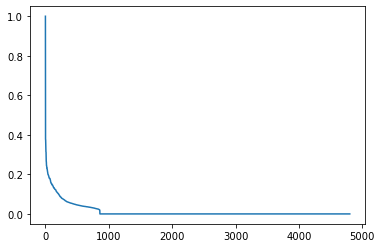

In [54]:
plt.plot(scores[(-scores).argsort()])

In [55]:
# get top 5 matches
# exclude self (similarity between query and itself yields max score)
recommended_idx = (-scores).argsort()[1:6]

In [56]:
# convert indices back to titles
df['title'].iloc[recommended_idx]

3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object

In [59]:
# create a function that generates recommendations
def recommend(title):
  # get the row in the dataframe for this movie
  idx = movie2idx[title]
  if type(idx) == pd.Series:
    idx = idx.iloc[0]

  # calculate the pairwise similarities for this movie
  query = x[idx]
  scores = cosine_similarity(query, x)

  # currently the array is 1 x N, make it just a 1-D array
  scores = scores.flatten()

  # get the indexes of the highest scoring movies
  # get the first K recommendations
  # don't return itself!
  recommended_idx = (-scores).argsort()[1:6]

  # return the titles of the recommendations
  return df['title'].iloc[recommended_idx]

In [60]:
print("Recommendations for 'Scream 3':")
print(recommend('Scream 3'))

Recommendations for 'Scream 3':
3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object


In [61]:
print("Recommendations for 'Mortal Kombat':")
print(recommend('Mortal Kombat'))

Recommendations for 'Mortal Kombat':
1611              Mortal Kombat: Annihilation
1670                       DOA: Dead or Alive
3856              In the Name of the King III
1001    Street Fighter: The Legend of Chun-Li
2237                        Alone in the Dark
Name: title, dtype: object


In [62]:
print("Recommendations for 'Runaway Bride':")
print(recommend('Runaway Bride'))

Recommendations for 'Runaway Bride':
4115                    House of D
2325    My Big Fat Greek Wedding 2
4604         It Happened One Night
3313                  An Education
2689            Our Family Wedding
Name: title, dtype: object
